# Setting up our Notebook

In this notebook, the setup and exploration of the environment heavily follows Nicholas Renotte's YouTube tutorial *Build an Mario AI Model with Python | Gaming Reinforcement Learning* at: https://www.youtube.com/watch?v=2eeYqJ0uBKE&t=1982s

The implementation of the REINFORCE algorithm is a modified version of the example script found in *Deep Reinforcement Learning with Python*.

Pertinent Links:

Super Mario RL: https://pypi.org/project/gym-super-mario-bros/

Nes Py: https://pypi.org/project/nes-py/

OpenAI Gym: https://gym.openai.com/

In [1]:
# Standard Imports
import random
import numpy as np
import matplotlib.pyplot as plt

# RL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import gym
import numpy as np
import seaborn_image as isns
from scipy.signal import convolve, gaussian
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms as T

# Misc
import os
import io
import base64
import time
import glob
from PIL import Image
# from IPython.display import HTML

In [2]:
# Import the game
import gym_super_mario_bros

# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace # Needed for changing the action space

# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Misc
from gym.spaces import Box
from gym.wrappers import FrameStack

# REINFORCE Review

## Basic Overview of Policy Gradient Algorithms

The REINFORCE algorithm starts from the concept of a trajectory, $\large \tau$, generated by an agent taking actions in states according to some policy parameterized (and therefore, an estimate) by $\mathbf{\theta}$:
$$a \sim \hat{\pi}(s, \mathbf{\theta})$$

This action could be discrete, as in this script, in which case the output of $\hat{\pi}(s, \mathbf{\theta})$ is then a *Categorical Distribution* and the action must then be *sampled*, or, in the continuous case, a $d$-dimensional multivariate normal distribution.

The agent follows the policy and generates the trajectory $\large \tau$: 

$$ s_1 \rightarrow a_1 \rightarrow s_2 \rightarrow a_2 \rightarrow .... \rightarrow s_{T-1} \rightarrow a_{T-1} \rightarrow s_T \rightarrow a_T$$ 

The probability of trajectory $\large \tau$ depends on the transition probabilities $p(s_t+1 | s_t, a_t)$ and the policy $\hat{\pi}(s, \mathbf{\theta})$. It is given by the expression:

$$p_\theta(\tau) = p_\theta(s_1, a_1, s_2, a_2, ..., s_T, a_T) = p(s_1)\prod_{t=1}^{T}\hat{\pi}(a_t|s_t,\mathbf{\theta})p(s_{t+1}|s_t,a_t)$$

The expected return, which will generally be (or some variation thereof) our objective function $J$, from following the policy $\pi$ is given by:

$$J(\theta) = R(\theta)_{expected} = \mathbf{E}_{\tau \sim p_\mathbf{\theta}(\tau)} \left[ \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right]$$

After some mathematical manipulation, we can calculate $\nabla_{\theta} J(\theta)$ as:

$$\nabla_{\theta} J(\theta) =  \mathbf{E}_{\tau \sim p_\theta(\tau)} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \hat{\pi}(a_t|s_t,\mathbf{\theta})} \right) \left( \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right) \right] $$

We can now replace the outer expectation with an estimate over multiple trajectories to get the following expression for the gradient of policy objective:

$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \hat{\pi}_\theta(a_t^i|s_t^i,\mathbf{\theta})} \right) \left( \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right) \right] $$

where i denotes the $i^{th}$ trajectory. 

Finally, we will use *Gradient Ascent*, as opposed to the normal *Descent*:

$$\mathbf{\theta}_{k+1}=\mathbf{\theta}_k+\eta \nabla _{\mathbf{\theta}_k} J(\mathbf{\theta}_k)$$

## Rewards to Go Trick


We drop the reward terms that came before time t as at time t, the action we take can only impact the reward which comes at time t and later. This leads to changing the 2nd inner sum going from $t’=t$ to $T$ instead of earlier sum over $t’$ going from $t’=1$ to $T$. i.e. the start index is now $t’=t$ and not $t=1$. The revised expression is given below:


$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} \right) \left( \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i \right) \right] $$

However, we note that $\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$ is just the Q-value of the state and action at time $t'=t$, so we can replace it with $Q_t ^i = \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$. We now have:

$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T}   \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} Q_t ^i \right]$$

## Entropy and Regularization with Rewards to Go

We will implement a pseudo loss function, whose derivative will give us $\nabla_{\theta} R(\theta)$. Also. as PyTorch/TensorFlow carryout a gradient Step, we will convert maximization to minimization by changing the sign of this objective function.

$$\mathcal{L}_{CrossEntropy}(\theta) = - J_{approx}(\theta) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \log{ \pi(a_t^i|s_t^i,\mathbf{\theta})}  Q_t ^i \right]$$

To summarize, we will pass the state `s` through the network to get $\log{ \pi(s_t^i,\mathbf{\theta})}$. We will calculate the cross-entropy loss for the actions actually seen in the trajectory. We will then calculate the weighted mean of these individual loss terms in the trajectory with weights being the rewards-to-go $\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$

This will be followed by a gradient step in -ve direction of weighted NLL (negative log loss) i.e. in positive direction of the gradient of $J(\theta)= - \mathcal{L}_{Cross Entropy}(\theta)$ 

We also add a regularization term known as Entropy. The entropy of a distribution is defined as:

$$H(X) = \beta \sum_{x \in X} -p(x)log(p(x))$$

To keep enough exploration, we will want the probability to have a spread out distribution and not let the probability distribution to collapse to a single value or a small region too soon. BIgger the spread of a distribution, higher the entropy $H(x)$ of a distribution. Accordingly, the term fed into PyTorch/TensorFlow minimizer is:


$$\mathcal{L}(\theta) = - J_{approx}(\theta) - H(\mathcal{A}) = - \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \log{ \pi(a_t^i|s_t^i,\mathbf{\theta})}  Q_t ^i - \beta \sum_{a \in \mathcal{A}} \pi(a|s_t^i,\mathbf{\theta})\log{ \pi(a|s_t^i,\mathbf{\theta})} \right] $$

# Exploring the game

In [3]:
# Setting up the game

env = gym_super_mario_bros.make('SuperMarioBros-v0')

In [4]:
# Exploring the types of movement

print('The RIGHT_ONLY action space:', RIGHT_ONLY)
print('\n')
print('The SIMPLE_ACTION action space:', SIMPLE_MOVEMENT)
print('\n')
print('The COMPLEX_ACTION action space:', COMPLEX_MOVEMENT)

The RIGHT_ONLY action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]


The SIMPLE_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


The COMPLEX_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


In [5]:
# Exploring the observation space

env.observation_space.shape

(240, 256, 3)

So, we have each frame being 240 $\times$ 256 pixels with 3 channnels (RBG).

Let's choose the simple movements for ease of training.

## Random Actions

In [6]:
# Taking random actions

def random_actions(game, movement, num_actions, render):
    
    """
    game is the game name.
    movements is the type of movement where there are options. 'None' will skip this.
    num_actions is the number of steps.
    render determines if the game will be displayed, determined with True
    """
    rewards = []
    done = True
    env = gym_super_mario_bros.make(game)
    if movement != 'None':
        env = JoypadSpace(env, movement)

    # Loop through each frame in the game
    for step in range(num_actions): 
        # Start the game to begin with 
        if done == True: 
            env.reset()
        # Do random actions
        state, reward, done, info = env.step(env.action_space.sample())
        if render == True:
            env.render()
        rewards.append(reward)
         
    # Close the game and return the rewards
    env.close()
    return np.sum(rewards)

In [7]:
print('The reward in this trajectory is:', random_actions('SuperMarioBros-v0', SIMPLE_MOVEMENT, 1000, True))

C:\Users\chris\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


The reward in this trajectory is: 759


# Preprocessing the Environment

In [8]:
# Importing wrappers

# Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [9]:
# Setting up the environment

def set_up_env(game, movement, grayscale, frame_stacking, frames, order):

    env = gym_super_mario_bros.make(game)
    env = JoypadSpace(env, movement)
    if grayscale == True:
        env = GrayScaleObservation(env, keep_dim=True)
    env = DummyVecEnv([lambda: env])
    if frame_stacking == True:
        env = VecFrameStack(env, frames, channels_order=order)
        
    return env

### Exploring what the GrayScaleObservation and VecFrameStack do

#### VecFrameStack and GrayScaleObservation turned off

In [10]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, False, 4, 'last')

State Shape (1, 240, 256, 3)


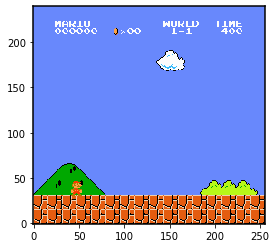

In [11]:
state = env.reset()
print('State Shape', state.shape)
plt.imshow(state[0]).origin='upper'

#### GrayScaleObservation Off and VecFrameStack On

In [12]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, True, 4, 'last')

State Shape (1, 240, 256, 12)


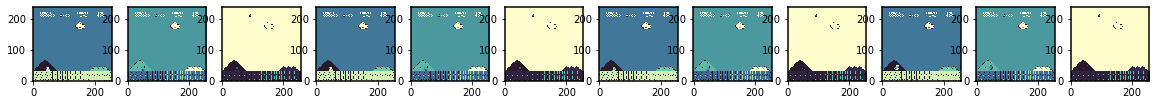

In [13]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(12): # So there'll be 4 images with 3 channels
    plt.subplot(1,12,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

#### GrayScaleObservation and VecFrameStack On

In [14]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')

State Shape (1, 240, 256, 4)


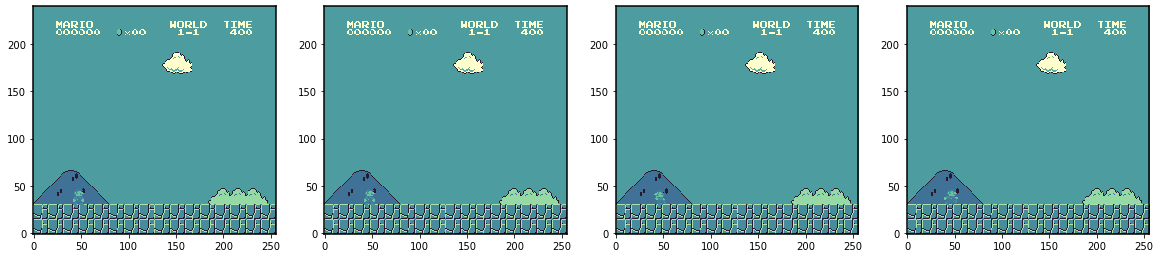

In [15]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(state.shape[3]): # So there'll be 4 images
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

## Setting up the device

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Setting up our agent to be trained with REINFORCE

In [17]:
# Getting the observation and action shape for our neural net

state_shape, n_actions = env.observation_space.shape, env.action_space.n
state_dim = state_shape
print('State Shape:', state_dim)
print('Number of actions:',n_actions)

State Shape: (240, 256, 4)
Number of actions: 7


In [18]:
# Defining our neural network

class RAgent(nn.Module):
    def __init__(self, state_shape, n_actions):
        super().__init__()
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        self.conv = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=8, stride=4),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten())
        self.fc = nn.Sequential(nn.Linear(288, n_actions))
        
    def forward(self, state_t):
        x = self.conv(state_t)
        x= self.fc(x)
        return x

In [19]:
# Instantiating the agent

agent = RAgent(state_shape, n_actions)

# Trajectory Calculations

We will use this function to generate the trajectory. It will not be used for doing back propagation. So we will use PyTorch `no_grad()` to avoid gradient calculations. 

## Generating Trajectory from Action Probabilities

In [20]:
# Probability of the actions

def predict_probs(states):
    """
    params: states: [batch, state_dim] Note that in generate_trajectory, batch_size is 1, as it is finding the probabilities
    for each step.
    Feeds into agent and returns probs: [batch, n_actions]
    """
    
    states = torch.tensor(states, device=device, dtype=torch.float32)
    
    with torch.no_grad():
        
        # Reshaping and rearranging the states
        states = torch.squeeze(states)
        states = states.transpose(0,2)
        states = states.transpose(1,2)
        states = states.unsqueeze(0)
        
        # Passing the states through the neural net for the logits
        logits = agent(states)
    probs = nn.functional.softmax(logits, -1).detach().numpy()
    
    return probs

In [21]:
# Generate a trajectory

def generate_trajectory(env, n_steps=512):
    """
    Play a session and generate a trajectory of n_steps one step at a time
    returns: arrays of states, actions, rewards
    """
    states, actions, rewards = [], [], []
    
    # Initialize the environment
    s = env.reset()
    
    # Generate n_steps of trajectory:
    for t in range(n_steps):
        action_probs = predict_probs(np.array([s]))[0]
        
        # Sample action based on action_probs
        a = [np.random.choice(n_actions, p=action_probs)]

        next_state, r, done, _ = env.step(a)
        
        # Update arrays
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = next_state
        if done:
            break
    return states, actions, rewards

## Calculate Rewards to Go

 $Q_t ^i = \sum_{t'=t}^{T} \gamma^{t-t'} r_{t'+1}$

In [22]:
# Rewards to Go

def get_rewards_to_go(rewards, gamma=0.99):
    
    T = len(rewards) # Total number of individual rewards
    # Empty array to return the rewards to go
    rewards_to_go = [0]*T 
    rewards_to_go[T-1] = rewards[T-1]
    
    for i in range(T-2, -1, -1): # Go from T-2 to 0
        rewards_to_go[i] = gamma * rewards_to_go[i+1] + rewards[i]
    
    return rewards_to_go

# REINFORCE Training

We will calculate the loss and take a gradient step. We will use Adam Optimizer

We are taking only one trajectory. so N=1. We will however, average it over the number of actions to get the average loss. So the function we will actually implement is as given below:

$$Loss(\theta) = - J(\theta) - H(\mathcal{A}) = - \frac{1}{T} \left[ \sum_{t=1}^{T} \log{ \pi(a_t|s_t,\mathbf{\theta})}  Q_t - \beta \sum_{a \in \mathcal{A}} \pi(a|s_t,\mathbf{\theta})\log{ \pi(a|s_t,\mathbf{\theta})} \right] $$

## Redefining our environment

In [23]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')

## Single trajectory training function

In [24]:
# Training over one trajectory

# Intializing the optimizer
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-5)

def train_one_trajectory(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    
    # Get rewards to go
    rewards_to_go = get_rewards_to_go(rewards, gamma)

    # Convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)    
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards_to_go = torch.tensor(rewards_to_go, device=device, dtype=torch.float)

    # Get action probabilities from states
    logits = agent(states) # Get's logits for the possible actions in each state/step of the trajectory. 
    # Has shape [n_steps, n_actions_per_state]
    probs = nn.functional.softmax(logits, -1) # Get's probabilities for the possible actions in each state/step of the
    # trajectory. Has shape [n_steps, n_actions_per_state]
    log_probs = nn.functional.log_softmax(logits, -1) # Get's log probabilities for the 
    # possible actions in each state/step of the trajectory. Has shape [n_steps, n_actions_per_state]
    
    log_probs_for_actions = log_probs[range(len(actions)), actions] # Log probabilities for the actions it ACTUALLY took.
    # Has size [n_steps, n_steps]
    
    # Compute loss to be minimized
    J = torch.mean(log_probs_for_actions*rewards_to_go) # Multiplies each log probability for the action ACTUALLY
    # taken at step t the Rewards to Go from that step, then divides by the number of trajectories. Produces a single number
    H = -(probs*log_probs).sum(-1).mean() # Multiplies each action's probability by its log probability in each step,
    # sums them across each step, and then divides by the number of steps. Produces a single number
    
    loss = -(J+entropy_coef*H)

    # Updating the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return np.sum(rewards) # To show progress in training

## Train the agent

In [25]:
# Training function

def reinforce_training(iterations):
    
    total_rewards = []
    for i in range(iterations):
        print('Step', i)
        states, actions, rewards = generate_trajectory(env)    
        states = torch.tensor(states).squeeze()
        states = states.transpose(1,3)
        states = states.transpose(2,3)
        reward = train_one_trajectory(states, actions, rewards)
        total_rewards.append(reward)
        print('Reward this loop:', total_rewards[-1])
    env.close()
    print('List of rewards', total_rewards)    

In [44]:
# Running the loop

start = time.time()
reinforce_training(200)
end = time.time()
print('The training took', round(end-start,3), 'seconds')

# Evaluation of the agent

In [27]:
# Evaluating our agent

def evaluate_mario(n_steps, render):

    rewards = []
    
    # Initialize the environment
    env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')
    s = env.reset()
    
    # Generate n_steps of trajectory:
    for t in range(n_steps):
        action_probs = predict_probs(np.array([s]))[0]
        
        # Sample action based on action_probs
        a = [np.random.choice(n_actions, p=action_probs)]

        next_state, r, done, _ = env.step(a)
        if render == True:
            env.render()

        rewards.append(r)
        
        s = next_state
        if done:
            break
    env.close()

    return np.sum(rewards)

In [50]:
# Single play-through

print('The agent recieved a total reward in one playthrough of', evaluate_mario(1000, True))

The agent recieved a total reward in one playthrough of 1912.0


In [43]:
# Multiple play-throughs

rewards_list = []
n_traj = 10
for i in range(n_traj):
    rewards_list.append(evaluate_mario(1000, False))
print('The average reward after', n_traj, 'trajectories is', np.mean(rewards_list))

The average reward after 10 trajectories is 1360.4


# Saving and Reloading the agent

In [46]:
# Saving an agent

torch.save(agent, 'Models/REINFORCE.h5')

In [49]:
# Loading an agent

agent = torch.load('Models/REINFORCE.h5')

# Confirming it has the architecture we want
agent.eval()

RAgent(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(32, 32, kernel_size=(8, 8), stride=(4, 4))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=288, out_features=7, bias=True)
  )
)